In [ ]:
# Install libraries (assuming a Google Colab environment)
!pip install torch torchvision albumentations opencv-python tqdm matplotlib segmentation-models-pytorch --quiet

# STEP 1 — SETUP & ENVIRONMENT PREP

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T # Renamed to T for convenience in one of the new cells
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import torch.nn as nn
import torch.optim as optim
import random


# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Running on: {device}")

# Folder structure
base_dir = "/content/Cell_Segmentation"
os.makedirs(f"{base_dir}/data/images", exist_ok=True)
os.makedirs(f"{base_dir}/data/masks", exist_ok=True)
os.makedirs(f"{base_dir}/models", exist_ok=True)
os.makedirs(f"{base_dir}/outputs", exist_ok=True)

print("📁 Project structure created successfully!")

✅ Running on: cuda
📁 Project structure created successfully!


In [ ]:
# Mount Google Drive (from original notebook)
from google.colab import drive
drive.mount('/content/drive')

# Create dataset directories and unzip files (assuming paths from original notebook)
!mkdir -p /content/dataset/train
!mkdir -p /content/dataset/test

!unzip -o "/content/drive/MyDrive/CellSegmentation/stage1_train.zip" -d /content/dataset/train
!unzip -o "/content/drive/MyDrive/CellSegmentation/stage1_test.zip" -d /content/dataset/test

# Verify data structure
train_path = "/content/dataset/train"
test_path = "/content/dataset/test"

print("Train folders:", len(os.listdir(train_path)))
print("Test folders:", len(os.listdir(test_path)))

# Show a sample folder and its contents
sample_folder = os.listdir(train_path)[0]
print("\nSample folder:", sample_folder)
print("Contents:", os.listdir(os.path.join(train_path, sample_folder)))

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f/images/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f.png  
  inflating: /content/dataset/train/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f/masks/03a82fbca4e3a18098034f787e3d2b03593ebd5fe9275c109be16ad524aeb234.png  
  inflating: /content/dataset/train/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f/masks/10bdfc12f516cb4565a4d692cfd2f93a3519bb499a40bac87f00a3d31a499ee3.png  
  inflating: /content/dataset/train/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f/masks/34fe07fbcd3b8656d851f3171c7e95b29eb66504c8f1d60a8eb3b2eb9c9a6469.png  
  inflating: /content/dataset/train/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f/masks/3b80886db302439e1cbb094a7189199b8a6e3956682b978b8d6e3f98619a82db.png  
  inflating: /content/dataset/train/d0f2a00d3155c243048bc4

In [ ]:
# STEP 3 — CUSTOM DATASET & LOSS FUNCTION

class CellDataset(Dataset):
    """
    A PyTorch Dataset for the Kaggle 2018 Data Science Bowl (Cell Segmentation).
    It aggregates multiple mask files per image into a single binary mask.
    """
    def __init__(self, root_folders, transform=None, image_size=(128, 128)):
        # If root_folders is a single string (for test data), convert to list of subfolders
        if isinstance(root_folders, str):
            self.folder_list = [os.path.join(root_folders, f) for f in os.listdir(root_folders)]
        else:
            self.folder_list = root_folders

        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        folder = self.folder_list[idx]

        # Assume the image is the first (and only) .png in the 'images' subdirectory
        image_dir = os.path.join(folder, 'images')
        image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

        if not image_files:
            return None, None # Skip if no image found

        image_path = os.path.join(image_dir, image_files[0])
        image = Image.open(image_path).convert('RGB')

        # --- Handle Masks (Only for Train/Val) ---
        mask_dir = os.path.join(folder, 'masks')
        if os.path.exists(mask_dir):
            mask_files = os.listdir(mask_dir)

            # Initialize an empty mask with the original image dimensions
            mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)

            # Aggregate all individual masks by taking the maximum (logical OR)
            for mask_file in mask_files:
                mask_path = os.path.join(mask_dir, mask_file)
                # Open as grayscale ('L')
                mask_ = np.array(Image.open(mask_path).convert('L'))
                mask = np.maximum(mask, mask_)

            # Resize the image and the aggregated mask
            image = image.resize(self.image_size)
            mask = Image.fromarray(mask).resize(self.image_size, resample=Image.Resampling.NEAREST)

            # Apply image transforms and convert mask to tensor
            if self.transform:
                image = self.transform(image)
            mask = T.ToTensor()(mask)

            return image, mask
        else:
            # For test data where only images are needed, return image and None/placeholder mask
            image = image.resize(self.image_size)
            if self.transform:
                image = self.transform(image)
            return image, torch.zeros((1,) + self.image_size) # Placeholder mask for test set if no real mask exists


# --- Custom Loss Functions ---

def dice_loss(pred, target, smooth=1e-5):
    """Calculates the Sørensen–Dice loss for image segmentation."""
    pred = torch.sigmoid(pred)
    # Flatten spatial dimensions (H*W) to allow easier sum
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

class DiceBCELoss(nn.Module):
    """Combines Binary Cross-Entropy (BCE) with Logits and Dice Loss."""
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        d_loss = dice_loss(pred, target)
        # Simple weighted sum: BCE + Dice Loss
        return bce_loss + d_loss

In [ ]:
# STEP 4 — DATA LOADERS AND MODEL INIT

train_root = "/content/dataset/train"
all_folders = [os.path.join(train_root, f) for f in os.listdir(train_root)]

# Split data into training and validation sets
train_folders, val_folders = train_test_split(all_folders, test_size=0.1, random_state=42)

# Define simple transforms (Resize and ToTensor)
data_transforms = T.Compose([
    T.Resize((128, 128)), # Ensure original size is used for consistency with CellDataset's resize
    T.ToTensor(),
])

# Collation function to handle None returned by the Dataset (e.g., if a folder has no mask, though rare in this dataset)
def collate_fn(batch):
    # Filter out None entries (where image or mask might be missing)
    batch = [b for b in batch if b[0] is not None]
    if len(batch) == 0:
        return None, None
    # Use default collate for the remaining valid batch items
    return torch.utils.data.dataloader.default_collate(batch)

# Create Datasets
train_dataset = CellDataset(train_folders, transform=data_transforms, image_size=(128, 128))
val_dataset = CellDataset(val_folders, transform=data_transforms, image_size=(128, 128))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

dataloaders = {'train': train_loader, 'val': val_loader}

print(f"✅ Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"✅ Input image size set to (128, 128) for training.")


# --- Model Initialization ---
model = smp.Unet(
    encoder_name="resnet34",        # backbone encoder
    encoder_weights="imagenet",     # use pre-trained weights
    in_channels=3,                  # RGB input
    classes=1,                      # binary segmentation (cell or no cell)
)

model = model.to(device)
print("✅ Model (Unet with ResNet34) ready on:", device)

✅ Train samples: 603, Validation samples: 67
✅ Input image size set to (128, 128) for training.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


✅ Model (Unet with ResNet34) ready on: cuda


In [ ]:
# STEP 5 — TRAINING LOOP

# --- Initialize Loss & Optimizer ---
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5 # Set epochs as per the original run

# --- Training Function ---
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Training on: {device}")

    # Store metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            dice_score = 0.0
            total_samples = 0

            for inputs, masks in tqdm(dataloaders[phase]):
                if inputs is None: # Skip if collate_fn returned None
                    continue

                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # Ensure masks is float for loss calculation
                    loss = criterion(outputs, masks.float())

                    # Calculate Dice Coefficient (for reporting)
                    # Use a binary prediction for the Dice metric, but keep outputs (logits) for loss
                    preds_binary = torch.sigmoid(outputs) > 0.5
                    dice_coeff = 1 - dice_loss(outputs, masks.float()) # Use outputs directly for dice_loss to match original notebook's logic

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                dice_score += dice_coeff.item() * inputs.size(0)
                total_samples += inputs.size(0)


            epoch_loss = running_loss / total_samples
            epoch_dice = dice_score / total_samples

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_dice'].append(epoch_dice)

            print(f"{phase} Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f}")

    print("✅ Training Complete!")
    return model, history


# Run the training process

trained_model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Training on: cuda

Epoch 1/5
------------------------------


100%|██████████| 76/76 [00:46<00:00,  1.64it/s]


train Loss: 1.1096 | Dice: 0.3705


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


val Loss: 0.8284 | Dice: 0.4797

Epoch 2/5
------------------------------


100%|██████████| 76/76 [00:32<00:00,  2.33it/s]


train Loss: 0.7156 | Dice: 0.5437


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


val Loss: 0.6625 | Dice: 0.5694

Epoch 3/5
------------------------------


100%|██████████| 76/76 [00:35<00:00,  2.12it/s]


train Loss: 0.5631 | Dice: 0.6231


100%|██████████| 9/9 [00:02<00:00,  3.26it/s]


val Loss: 0.5269 | Dice: 0.6418

Epoch 4/5
------------------------------


100%|██████████| 76/76 [00:32<00:00,  2.36it/s]


train Loss: 0.4778 | Dice: 0.6735


100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


val Loss: 0.4414 | Dice: 0.6989

Epoch 5/5
------------------------------


100%|██████████| 76/76 [00:31<00:00,  2.38it/s]


train Loss: 0.3985 | Dice: 0.7258


100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

val Loss: 0.4009 | Dice: 0.7211
✅ Training Complete!


In [ ]:
# STEP 6 — MODEL EVALUATION AND VISUALIZATION
# 1. DATA COLLECTION & SEGMENTATION METRICS (DICE/IoU)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import torch
import numpy as np

# Re-define the full data collection logic outside the function
model = trained_model.eval()
device = next(model.parameters()).device

all_preds_flat = []
all_targets_flat = []
dice_scores = []
iou_scores = []

with torch.no_grad():
    for inputs, masks in dataloaders['val']:
        if inputs is None:
            continue

        inputs, masks = inputs.to(device), masks.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)

        # --- Segmentation Metrics (Dice & IoU) ---
        preds_binary = (preds > 0.5).float()

        # Sum over H and W, then average over batch and channels (channel dim is 1)
        intersection = (preds_binary * masks).sum(dim=(2, 3))
        union = (preds_binary + masks).sum(dim=(2, 3)) - intersection

        # Add a small epsilon for stability
        epsilon = 1e-7
        dice = (2. * intersection + epsilon) / (preds_binary.sum(dim=(2, 3)) + masks.sum(dim=(2, 3)) + epsilon)
        iou = (intersection + epsilon) / (union + epsilon)

        # Dice and IoU are per-image (batch_size x 1), average over the batch
        dice_scores.extend(dice.mean(dim=1).cpu().numpy())
        iou_scores.extend(iou.mean(dim=1).cpu().numpy())

        # --- Classification Metrics Data ---
        # Flatten to 1D arrays for sklearn (per-pixel comparison)
        targets_flat = masks.cpu().numpy().astype(int).flatten()
        preds_flat = (preds_binary.cpu().numpy()).astype(int).flatten()

        all_preds_flat.extend(preds_flat)
        all_targets_flat.extend(targets_flat)

# Convert lists to final numpy arrays
all_targets_flat = np.array(all_targets_flat)
all_preds_flat = np.array(all_preds_flat)
avg_dice = sum(dice_scores)/len(dice_scores)
avg_iou = sum(iou_scores)/len(iou_scores)

print(f"Validation Dice Score (Per Image Avg): {avg_dice:.4f}")
print(f"Validation IoU Score (Per Image Avg): {avg_iou:.4f}")

Validation Dice Score (Per Image Avg): 0.8271
Validation IoU Score (Per Image Avg): 0.7352


In [ ]:
# 2. PER-PIXEL CLASSIFICATION METRICS (MODEL EVALUATION AND VISUALIZATION)

acc = accuracy_score(all_targets_flat, all_preds_flat)
prec = precision_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=0)
rec = recall_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=0)
f1 = f1_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=0)

print(f"📊 Per-Pixel Model Performance (Weighted):")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision (Weighted): {prec:.4f}")
print(f"Validation Recall (Weighted): {rec:.4f}")
print(f"Validation F1 Score (Weighted): {f1:.4f}")

# 3. CLASSIFICATION REPORT

print("\n📊 Classification Report:")
print(classification_report(all_targets_flat, all_preds_flat, zero_division=0))

📊 Per-Pixel Model Performance (Weighted):
Validation Accuracy: 0.9648
Validation Precision (Weighted): 0.9649
Validation Recall (Weighted): 0.9648
Validation F1 Score (Weighted): 0.9649

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    951395
           1       0.87      0.87      0.87    146333

    accuracy                           0.96   1097728
   macro avg       0.92      0.92      0.92   1097728
weighted avg       0.96      0.96      0.96   1097728



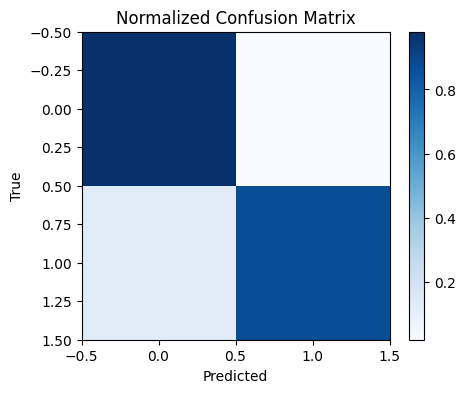

In [ ]:
# 4. CONFUSION MATRIX (MODEL EVALUATION AND VISUALIZATION)

import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets_flat, all_preds_flat, normalize='true')
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

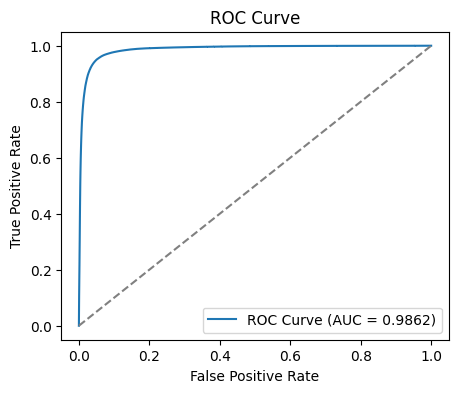

In [ ]:
# 5. ROC CURVE AND AUC (MODEL EVALUATION AND VISUALIZATION)

all_labels_roc = []
all_probs_roc = []

with torch.no_grad():
    for inputs, masks in dataloaders['val']:
        if inputs is None:
            continue

        inputs, masks = inputs.to(device), masks.to(device)
        outputs = model(inputs)

        # Get continuous probability predictions (Sigmoid output)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        # Get binary labels
        labels = masks.cpu().numpy().astype(int).flatten()

        all_probs_roc.extend(probs)
        all_labels_roc.extend(labels)

all_probs_roc = np.array(all_probs_roc)
all_labels_roc = (np.array(all_labels_roc) > 0.5).astype(np.uint8)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})') # Using :.4f for better precision
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

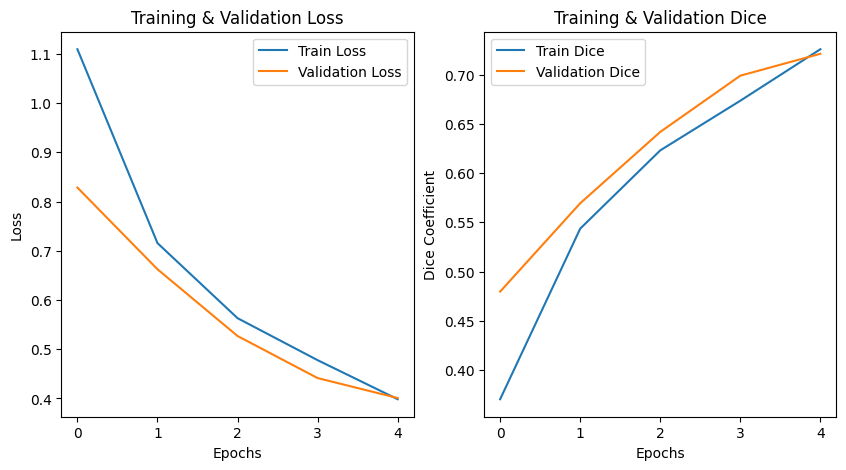


✅ Model saved successfully as: unet_final_model_20251029_175903.pth


In [ ]:
# STEP 7 — PLOTS AND MODEL SAVING

# --- Plot Loss and Dice ---
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Training & Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()

# --- Save Model ---
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"unet_final_model_{timestamp}.pth"

# Save the state dictionary of the trained model
torch.save(trained_model.state_dict(), model_path)

print(f"\n✅ Model saved successfully as: {model_path}")

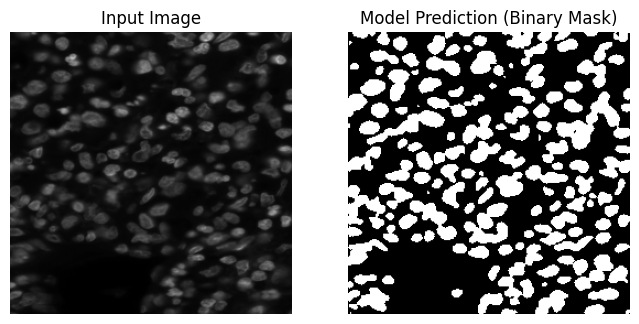

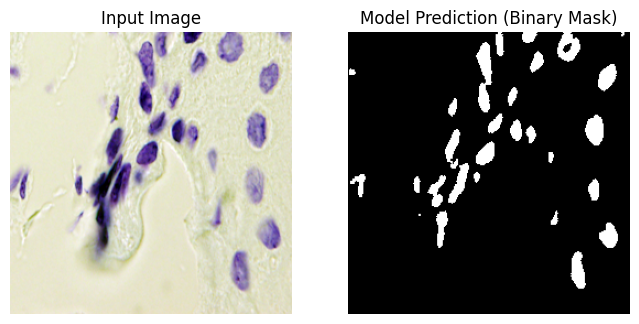

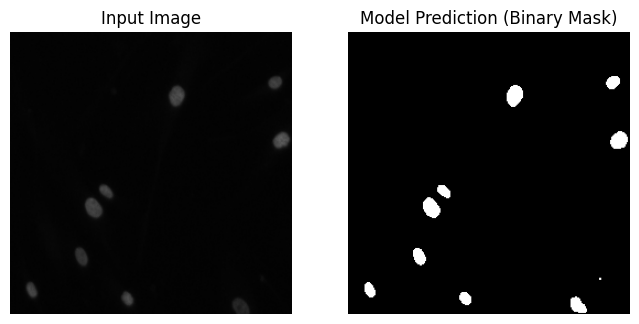

In [ ]:
# STEP 8 — PREDICTION ON TEST SET

# A simple test dataset for inference
test_dataset = CellDataset(
    "/content/dataset/test",
    transform=T.Compose([
        T.Resize((256, 256)), # Use a consistent inference size
        T.ToTensor()
    ]),
    image_size=(256, 256) # Ensure dataset class resizes to the inference size
)


def predict_from_test(model, test_dataset, num_samples=3):
    """Visualizes model predictions on random samples from the test set."""
    model.eval()
    device = next(model.parameters()).device

    # Pick random samples
    indices = random.sample(range(len(test_dataset)), num_samples)

    for i in indices:
        image, _ = test_dataset[i]  # Get the image

        # Unsqueeze to add batch dimension (Batch size of 1)
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_input)

            # Apply sigmoid and threshold to get binary prediction
            pred = torch.sigmoid(output).cpu().numpy()[0][0] > 0.5

        # Convert image tensor back to numpy array for plotting
        # (C, H, W) -> (H, W, C)
        img_np = image.cpu().numpy().transpose(1, 2, 0)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(img_np)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Model Prediction (Binary Mask)")
        plt.imshow(pred, cmap='gray')
        plt.axis('off')

        plt.show()

# Run prediction visualization
predict_from_test(trained_model, test_dataset, num_samples=3)

In [ ]:
# 1. TEST DATASET AND DATALOADER DEFINITION

import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import random

# Assuming the CellDataset class is defined (as it was in your notebook)
# and the test_path is correctly set.
test_path = "/content/dataset/test"

# Get all test folders (Image IDs)
test_folders = [os.path.join(test_path, f) for f in os.listdir(test_path)]

# Define transforms: only resize and ToTensor (no normalization or augmentation applied here
# as the original notebook did not explicitly define them for the test set)
test_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

# Initialize the Test Dataset
# We use the same image_size as training for consistent input shape.
test_dataset = CellDataset(
    test_folders,
    transform=test_transforms,
    image_size=(128, 128)
)

# Initialize the Test DataLoader
# We use a large batch size since we are only running inference
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"✅ Test samples initialized: {len(test_dataset)}")

✅ Test samples initialized: 65


🖼️ Visualizing 3 random predictions from the unseen Test Set...


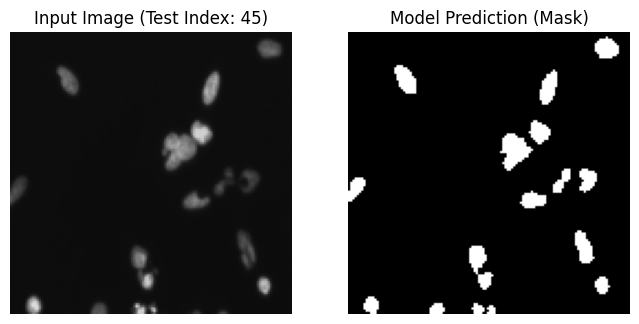

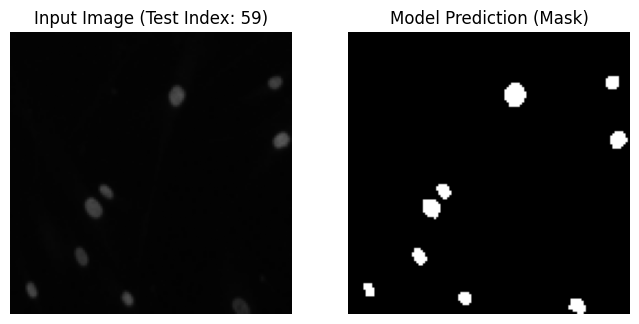

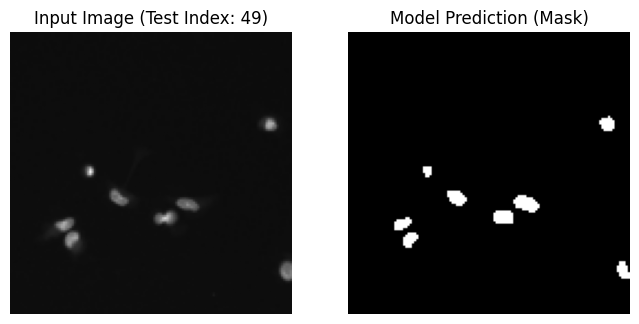

In [ ]:
# 2. RANDOM TEST PREDICTION VISUALIZATION

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image # For the internal logic of the CellDataset if run in a fresh kernel

def predict_from_test_and_visualize(model, dataset, num_samples=3):
    """
    Picks random images from the provided dataset (e.g., the unseen test set)
    and displays the model's segmentation prediction.
    """
    model.eval()
    device = next(model.parameters()).device

    # Filter out potential None entries from the list of folders before sampling
    valid_indices = [i for i, (img, mask) in enumerate(dataset) if img is not None]

    if len(valid_indices) < num_samples:
        print(f"❌ Not enough valid samples ({len(valid_indices)}) to draw {num_samples} predictions.")
        num_samples = len(valid_indices)

    # Pick random indices from the valid list
    sampled_indices = random.sample(valid_indices, num_samples)

    print(f"🖼️ Visualizing {num_samples} random predictions from the unseen Test Set...")

    for idx in sampled_indices:
        # The CellDataset for the test set returns (image, placeholder_mask)
        image_tensor, _ = dataset[idx]

        # Add batch dimension (1, C, H, W) and move to device
        image_input = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_input)

            # Apply sigmoid and threshold to get the binary mask prediction
            pred_prob = torch.sigmoid(outputs)
            pred_mask = (pred_prob.cpu().numpy()[0][0] > 0.5).astype('uint8')

        # Convert input image tensor (C, H, W) to numpy array (H, W, C) for plotting
        img_np = image_tensor.cpu().numpy().transpose(1, 2, 0)

        plt.figure(figsize=(8, 4))

        # Subplot 1: Input Image
        plt.subplot(1, 2, 1)
        plt.title(f"Input Image (Test Index: {idx})")
        plt.imshow(img_np)
        plt.axis('off')

        # Subplot 2: Model Prediction
        plt.subplot(1, 2, 2)
        plt.title("Model Prediction (Mask)")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.show()

predict_from_test_and_visualize(trained_model, test_dataset, num_samples=3)

In [ ]:
# This command saves the final state of the trained_model

torch.save(trained_model.state_dict(), "unet_final_model.pth")

In [ ]:
from IPython.display import clear_output
# This closes all active ipywidgets models and clears their state from the kernel
try:
    from ipywidgets import Widget
    Widget.close_all()
except:
    pass

print("Widget state cleaned!")

Widget state cleaned!
